# The implementation that follows is functional but incorrect because it uses a 1 dimensional decayed subspace

In [97]:
import qutip as qt
import sympy as sp
import numpy as np
from qutip.qip.operations import rz

# Variables Declaration

In [98]:
gamma = 1
gamma_f = 0.9
gamma_g = 0.1

a = 1 # Cf/C
b = gamma_f / gamma 

C = sp.symbols('C',positive=True)

Omega = 0.25*gamma*sp.sqrt(C)

DE =  gamma/2 * sp.sqrt(b)* sp.sqrt(4*a*C+b )
De =  a*C * gamma**2 /(2*DE)

DEt = (DE - 1j*gamma_f/2 - 1j*gamma_g/2 ) / gamma  #1j*gamma_g is also included. doesn't influence the results significantly
Det = (De - 1j*gamma/2 ) / gamma

# Hamiltonian as function of C

In [99]:
H_eff = sp.Matrix(np.zeros((5,5)))

for i in range(4):
    n = bin(i).count('1')  #counts the excitations

    Delta_n = (1j * Det/2 + n*C)  / (Det * (1j*DEt/2+C)  + DEt*n*C    )

    H_eff[i,i] = - Omega**2/(4*gamma) * sp.re(Delta_n)



# Lindblad operators as function of C

In [100]:
L_0 = sp.Matrix(np.zeros((5,5)))

for i in range(4):
    n = bin(i).count('1')

    frac = sp.sqrt(C)*Det*Omega / (Det * (1j*DEt/2+C  ) + n*DEt*C )

    L_0[4,i] = 1/(2*gamma) * frac


In [101]:
L_g = sp.Matrix(np.zeros((5,5)))

for i in range(4):
    n = bin(i).count('1')

    frac = (1j * Det/2 + n*C)* Omega  / (Det * (1j*DEt/2+C)  + DEt*n*C    )

    L_g[i,i] = sp.sqrt(gamma_g)/(2*gamma) * frac


In [102]:
L_f = sp.Matrix(np.zeros((5,5)))

for i in range(4):
    n = bin(i).count('1')

    frac = (1j * Det/2 + n*C)* Omega  / (Det * (1j*DEt/2+C)  + DEt*n*C    )

    L_f[4,i] = sp.sqrt(gamma_f)/(2*gamma) * frac

In [103]:
L_k0 = sp.Matrix(np.zeros((5,5)))

for i in [1,3]:
    n = bin(i).count('1')

    frac = sp.sqrt(C*C)*Omega / (Det * (1j*DEt/2+C  ) + n*DEt*C )

    L_k0[4,i] = -1/(2*sp.sqrt(gamma)) * frac

L_k1 = sp.Matrix(np.zeros((5,5)))

for i in [2,3]:
    n = bin(i).count('1')

    frac = sp.sqrt(C*C)*Omega / (Det * (1j*DEt/2+C  ) + n*DEt*C )

    L_k1[4,i] = -1/(2*sp.sqrt(gamma)) * frac

# Run the simulation for $C=100$ . In the 2015 paper $1 - P_{success}\approx 43 \%$

In [104]:
C_val = 100

H_eff_num = np.array( H_eff.subs(C,C_val)).astype(np.float64) #*2
H_obj = qt.Qobj(H_eff_num)

L_list = [ L_0, L_g, L_f, L_k0, L_k1]
L_list_num =  []
L_list_obj =  []
for l in range(len(L_list)):
    l_num = np.array( L_list[l].subs(C,C_val) ).astype(np.complex64)
    L_list_num.append(l_num)
    L_list_obj.append(qt.Qobj(l_num))


init_state = qt.Qobj(np.array([1,1,1,1,0])/2)
ideal_output  =  qt.Qobj(np.array([1,1,1,-1])/2)  #target state

gate_time =  np.abs( np.pi\
        /(H_eff_num[3,3]+H_eff_num[0,0]-H_eff_num[1,1]-H_eff_num[2,2]))

#ROTATIONS
r1 = - gate_time * (H_eff_num[0,0] - H_eff_num[2,2])
R1 = qt.tensor( rz(r1 ),qt.identity(2)).full()
R1 = qt.Qobj(R1)
r2 = - gate_time * (H_eff_num[0,0] - H_eff_num[1,1])
R2 = qt.tensor(qt.identity(2),rz(r2 )) .full()
R2 = qt.Qobj(R2)

#SIMULATION
times = np.linspace(0,gate_time,200)
sol = qt.mesolve(H_obj,  init_state, times, L_list_obj, [] )


#final density matrix 
dm_f = sol.states[-1].tidyup()

P_s = (1 -dm_f[4,4]) 

f_state = 1/P_s * dm_f.eliminate_states([4])

f_state_rotated =    R2*R1*f_state *R1.dag()*R2.dag()

Fidelity = qt.fidelity(f_state_rotated,ideal_output)


print(f'1-Psuccess: {1-P_s}')
print(f'Fidelity: {Fidelity}')

1-Psuccess: (0.6519634902845864+0j)
Fidelity: 0.9716644453959508


## Results are not in accordance with the paper. Manually setting the `H_eff_num*2` gives the correct results though. (second line of the above block)

# ~~~



# Plot the fidelity over time to ensure that we are not applying the Hamiltonian for more than needed

Text(0, 0.5, 'Fidelity wrt ideal output')

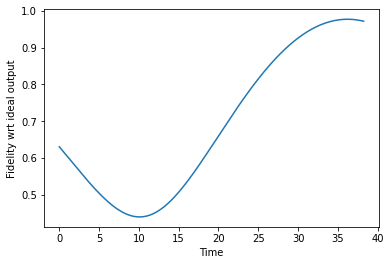

In [107]:
fid = []

for i in range(len(times)):
    dm = sol.states[i]
    p_s = (1 -dm[4,4]) 

    f_state = 1/p_s * dm.eliminate_states([4])

    f_state_rotated =    R2*R1*f_state *R1.dag()*R2.dag()
    
    fidelity = qt.fidelity(f_state_rotated,ideal_output)
    fid.append( fidelity )


import matplotlib.pyplot as plt

plt.plot(times,fid)
plt.xlabel('Time')
plt.ylabel('Fidelity wrt ideal output')
